In [1]:
import os
# from PIL import Image
#import matplotlib
#import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform, data, color, feature, filters
#import cv2 as cv

In [55]:
time_coeff = 1.200 #1.392

In [56]:
def get_screenshot():
    # Change 'platform-tools-windows' to 'platform-tools-macos' and 'adb.exe' to './adb' on macOS; you may need to use `chmod +X ../dependency/platform-tools-macos/adb` first
    os.system(
        'cd ../dependency/platform-tools-windows/ && adb.exe shell screencap -p /sdcard/autojump.png')
    os.system(
        'cd ../dependency/platform-tools-windows/ && adb.exe pull /sdcard/autojump.png ../../src/')

In [111]:
def press_screen(distance):
    # Change 'platform-tools-windows' to 'platform-tools-macos' and 'adb.exe' to './adb' on macOS; you may need to use `chmod +X ../dependency/platform-tools-macos/adb` first
    press_time = int(distance * time_coeff)
    os.system('cd ../dependency/platform-tools-windows/ && adb.exe shell input swipe 500 1000 500 1002 ' + str(press_time))

In [126]:
def edge_detc(img_gray):
    #img = np.mat(img_gray)
    #temp = img[:,:-1] - img[:,1:]
    #print(temp)
    #io.imshow(temp, cmap='gray')
    '''
    for i in range(img_gray.shape[0]):
        for j in range(1,img_gray.shape[1]):
            #if temp[i,j] != 0 :
            #    temp[i,j] = True
            #else :
            #    temp[i,j] = False
            if img_gray[i,j] != img_gray[i,j-1] | img_gray[i,j] != img_gray[i,j+1] :
                temp[i,j] = True
            else :
                temp[i,j] = False
        temp[i,0] = temp[i,-1] = False
    '''
    temp = abs(img_gray[:,:-1] - img_gray[:,1:])
    temp = temp > 0.001
    return temp

In [129]:
def main():
    # Code here
    # 截取屏幕
    get_screenshot()
    
    # 对截取到的图像进行压缩转换处理
    img_src = io.imread('autojump.png')               #读取原始图像
    img_src = img_src[400:1700,:,:]
    #img_bounder = feature.canny(color.rgb2gray(img_src),sigma=0)
    #img_bounder = transform.rescale(img_bounder,0.5)
    #io.imshow(img_src)
    img = transform.rescale(img_src,0.5) # 对图像进行压缩和裁剪以减小之后的运算量
    img_gray = color.rgb2gray(img)                    # 转化为灰度图
    #img_bounder = feature.canny(img_gray,sigma=0)   # 对灰度图进行边缘检测
    img_gray = 1 - img_gray                           # 对灰度图进行灰度翻转，以减小浅色背景对于相关结果的贡献，提高相关的准确率，但有时背景也可能出现较深颜色，此时误差较大
    #io.imshow(img_bounder)
    #io.imshow(img_gray)
    
    img_bounder = edge_detc(img_gray)[1:]
    io.imshow(img_bounder, cmap='gray')
    print(img_bounder)
    
    # player_template = cv.imread('src/jer.png')
    # player = cv.matchTemplate(img, player_template, cv.TM_CCOEFF_NORMED)
    
    # 遍历整个背景图片，与棋子的模板图片做相关，大于阈值后跳出循环
    threshold = 150;
    #mat1 = np.mat(jer_gray);
    mat1 = np.loadtxt(open('jer.csv','rb'), delimiter=',', skiprows=0)
    mat2 = np.mat(img_gray)
    row = img_gray.shape[0]; col = img_gray.shape[1]
    height = mat1.shape[0]; width = mat1.shape[1]
    #io.imshow(mat1,cmap = 'gray')
    #io.imshow(mat2,cmap = 'gray')
    # print(mat1.shape)
    # print(mat2.shape)
    flag1 = False; flag2 = False
    left = np.array([0,0]); right = np.array([0,0])
    for i in range(row-height):
        for j in range(col-width):
            mat3 = mat2[row-i-height:row-i, j:j+width]
            temp = np.sum(np.multiply(mat3, mat1))
            if temp > 1550 & ~flag1 :
                flag1 = True
                left = [i,j]
                #io.imshow(mat3,cmap='gray')
                break
            #if temp > 1550 && flag1 && ~flag2 :
                
            if temp > 1550 :
                print(i,j,temp)
            #if (i,j) == (313,313) :
            #    print((i,j),temp)
            #    io.imshow(mat3,cmap='gray')
        if flag1 :
            break
    
    left = left + np.array([1,1])             # 对检测到的棋子位置进行修正
    print('source:',left)
     
    # 对于经过边缘检测的图像，搜索下一个将要跳跃的块的顶点，以确定其水平方向的坐标，从而得到与棋子的距离
    target = np.array([0,0])
    flag = False
    mat4 = np.mat(img_bounder)      # 将边缘检测得到的图转化为矩阵，矩阵元素为boolean型变量
    #print(mat4)
    row = img_bounder.shape[0]; col = img_bounder.shape[1]
    for i in range(row) :
        for j in range(col) :
            if mat4[i,j] :
                target = [i,j]
                flag = True
                #print(i,j,mat4[i,j])
                break
        if flag :
            break
    
    print('target:',target)
    distance = 2 * abs(target[1] - left[1]) / 0.8
    print('distance:',distance)
    
    press_screen(distance)
    
    pass

d:\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
d:\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
d:\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
source: [257 381]
target: [159, 143]
distance: 595.0


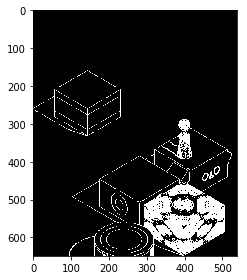

In [137]:
if __name__ == '__main__':
    main()

In [ ]:
jer = io.imread('jer0.png')                        # 读取棋子模板图像
jer_gray = color.rgb2gray(jer)                    # 转化为灰度图
jer_gray = 1 - jer_gray                           # 进行灰度反转
mat1 = np.mat(jer_gray)
#print(mat1)
for i in range(mat1.shape[0]) :
    for j in range(mat1.shape[1]) :
        if mat1[i,j] < 0.3 :
            mat1[i,j] = 0;
io.imshow(mat1,cmap='gray')
np.savetxt('jer.csv',mat1,delimiter=',')